# Project 2 Report

**Authors**: *Azfarul Islam* and *Callum Abbott*

**Date**: December, 2020

---

# 🚦 Introduction

A primary method of reporting road traffic by the Department for Transport (DfT) involves estimating *Average Annual Daily Flow* (AADF) of traffic on UK roads. Counts are manually performed at pre-determined locations (called 'count points'), periodically. Typically, these counts are collected over a 12-hour period, only on weekdays, between March to October. There may be inconsistencies in which roads are counted, year on year.

Utilising the public dataset under an [Open Government License](http://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/), we explore it to understand and present our insights on traffic trends in Scotland (because we are at the University of Edinburgh, obviously) covering a period from 2000 to 2019.

---

# 📐 Approach

Before we begin deriving insights from our primary dataset, we decided to perform some basic exploratory data analysis (EDA) in order to understand what we are dealing with. This would also help us confirm which questions we thought would be interesting to answer, and consequently decide what appropriate transformations of the dataset would be deemed necessary.

Before we started any code development, we summarised the outcomes we wished to achieve for each visualisation. This was followed with a breakdown of steps we would need to take to arrive at our planned visualisation (e.g. figure formatting, external data, pivotting, etc.).

After these steps, if we found any alternative avenues of interest, we either added or pivoted towards those as appropriate.

---

### 🐲 *There be dragons (i.e. code begins)*

In [4]:
# Importing relevant libraries
import numpy as np
import pandas as pd
import folium
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.ticker import FormatStrFormatter
import json
import os
import descartes
from shapely.geometry import Point, Polygon
from datetime import datetime

# Setting Pandas display parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

---

# 🧹🗺 Basic EDA

A quick set of EDA actions were performed where we simply observed the first few rows of data and referenced them against the descriptions for each column to ensure elements were as expected. We also utilised the `.info()` and `.describe()` methods for the dataframe to see the types of columns, as well as exploring summary statistics. 

Besides the specific questions we wanted to answer, this also helped us re-affirm any columns that we would not need to use.

---

### Exploring our data

In [5]:
# Read in data
df = pd.read_csv('data/dft_rawcount_region_id_3.csv', low_memory=False)

In [ ]:
df.head() # Quickly viewing variables

In [ ]:
df.describe(include='all') # Basic EDA

---

# 🧹 Tidying our data

Inspired by [TidyVerse](https://style.tidyverse.org) principles from R (thank you, *Hadley Wickham*), we decided to create a reduced data-frame which would only keep the signal and remove the noise, as it were. 

Here follows a set of transformations made to render our tidy dataframe.

### Removing unnecessary columns

Once we were mostly certain about the questions we wanted to answer, we could comfortably drop a large number of columns from the original dataframe. In some cases there was redundant data (such as `region_id` which contained only one value, or all the different types of HGV) in other cases, we simply did not need to keep that data. For HGVs, we only retained the `all_hgvs` column.

In [6]:
df_tidy = df.copy() # Tidy dataset storage

# Cols to drop
rm_cols = ['region_id', 'region_name', 'local_authority_id', 'road_type',
           'start_junction_road_name', 'end_junction_road_name',
           'year', 'easting', 'northing', 'link_length_miles', 'link_length_km', 'hgvs_2_rigid_axle',
           'hgvs_3_rigid_axle', 'hgvs_3_or_4_articulated_axle',
           'hgvs_4_or_more_rigid_axle', 'hgvs_5_articulated_axle',
           'hgvs_6_articulated_axle']

# Drop cols
df_tidy.drop(rm_cols, axis=1, inplace=True)

### Renaming Vehicle Labels 

We wanted to have more interpretable labels for each vehicle type, so we renamed them appropriately. This would make labelling in plots simpler.

In [7]:
new_names = ['bikes', 'motorcycles', 'cars', 'buses', 'lgvs', 'hgvs'] # More interpretable labels
name_mappings = dict(zip(df_tidy.columns[8:-1], new_names)) # Creating dict of label mappings
df_tidy.rename(columns=name_mappings, inplace=True) # Renaming columns

### Tidy Transformations

We noticed that there was a column called `all_motor_vehicles` which was a sum of counts per row for all vehicles save for bikes; we wanted to have a complete count which we called `all_vehicles`. 

As we knew we had interest in the type of road based on its letter designation, we utilised an anonymous function to extract that into a new column called `road_type`. Note that we dropped their original `road_type` column as we were not interested in it.]

Finally, we converted `count_date` to a `DateTime64` object, as we would utilise dates in a few of our questions.

In [8]:
# all_motor_vehicles --> all_vehicles (include bikes)
df_tidy['all_vehicles'] = df_tidy['bikes'] + df_tidy['motorcycles'] + df_tidy['cars'] + df_tidy['buses'] + \
                          df_tidy['lgvs'] + df_tidy['hgvs']

# New column for specifying whether road is: M, A, B, C, U
df_tidy = df_tidy.assign(
            road_type = lambda dataframe: dataframe['road_name'].map(lambda road_name: road_name[0]))

# Convert count_date to datetime format
df_tidy['count_date'] = pd.to_datetime(df['count_date'], format='%Y-%m-%d')

### Adding Population Data

We acquired population data covering mid-2019 estimates from [National Records of Scotland](https://www.nrscotland.gov.uk/statistics-and-data/statistics/statistics-by-theme/population/population-estimates/mid-year-population-estimates/mid-2019). Due to the Pandas-unfriendly structure of their dataset, we simply adapted it into a tiny dataset covering only the estimated populations for each local authority in Scotland.

We had to convert the `population` column into integers, and had to change the name of one of the local authorities (called, interchangeably: *Na h-Eileanan Siar*, *Comhairle nan Eilean Siar*, and *Eilean Siar*) to ensure there was parity across all dataframes. We merged the population data with our main dataframe.

⚠️ **Please note warning in code below**

In [9]:
# Read in population statistics
# Line(s) 5: National Records of Scotland
# URL: https://www.nrscotland.gov.uk/statistics-and-data/statistics/statistics-by-theme/population/population-estimates/mid-year-population-estimates/mid-2019
# Accessed on 31 Nov 2020.
pop_df = pd.read_csv('data/scotland-mid-year-pop-est-19.csv', header=None)

# Rename columns
pop_df.rename(columns={0: 'local_authority_name', 1: 'population'}, inplace=True)

# Convert population to int
pop_df.population = pop_df.population.str.replace(',', '')
pop_df.population = pop_df.population.astype('int') 

# String replaces to avoid join issues
pop_df.local_authority_name = pop_df.local_authority_name.str.replace('Na h-Eileanan Siar', 'Eilean Siar')
df_tidy.local_authority_name = df_tidy.local_authority_name.str.replace('Comhairle nan Eilean Siar', 'Eilean Siar')
df_tidy.local_authority_name = df_tidy.local_authority_name.str.replace('&', 'and')

# Overwrite df_tidy with full outer join with population data`
# WARNING: this operation is idempotent so repeated runs will keep adding a population column
# Must restart kernel if this needs to be run again 
df_tidy = pd.merge(df_tidy, pop_df, on='local_authority_name', how='outer')

In [10]:
df_tidy.head(100) # Final check of tidy dataset

,count_point_id,direction_of_travel,count_date,hour,local_authority_name,road_name,latitude,longitude,bikes,motorcycles,cars,buses,lgvs,hgvs,all_motor_vehicles,all_vehicles,road_type,population
0,931907,N,2019-06-17,18,City of Edinburgh,U,55.967806,-3.307580,8,2,290,5,20,0,317,325,U,524930
1,931907,S,2019-06-17,13,City of Edinburgh,U,55.967806,-3.307580,1,1,258,4,36,7,306,307,U,524930
2,931907,N,2019-06-17,9,City of Edinburgh,U,55.967806,-3.307580,5,1,270,5,44,8,328,333,U,524930
3,931907,S,2019-06-17,12,City of Edinburgh,U,55.967806,-3.307580,2,2,266,4,50,9,331,333,U,524930
4,931907,S,2019-06-17,10,City of Edinburgh,U,55.967806,-3.307580,4,0,247,8,35,8,298,302,U,524930
5,931907,S,2019-06-17,16,City of Edinburgh,U,55.967806,-3.307580,7,3,475,5,101,7,591,598,U,524930
6,931907,N,2019-06-17,15,City of Edinburgh,U,55.967806,-3.307580,8,1,335,4,61,2,403,411,U,524930
7,931907,S,2019-06-17,15,City of Edinburgh,U,55.967806,-3.307580,10,3,447,5,91,8,554,564,U,524930
8,931907,N,2019-06-17,14,City of Edinburgh,U,55.967806,-3.307580,4,0,397,5,59,10,471,475,U,524930
9,931907,S,2019-06-17,14,City of Edinburgh,U,55.967806,-3.307580,2,0,294,5,42,10,351,353,U,524930


We can happily confirm that our tidy dataframe has no missing (`NaN`) values!

---

# 🚲 Bikes observed per 10k residents per local authority

We wanted to investigate data around bikes, and thought that bike observations per local authority name would be interesting to start with. However, we need to establish the following caveats:
1. Count data of bikes is assumed to be representative of the prevalence of bikes in the authority
2. A bike count within a local authority maps to that bike actually belonging to that authority
3. Double counting effects are ignored

With regards to caveats 1 and 2, we think those are reasonable assumptions since bikes are used for micro-mobility in the majority of cases.

Our visualisation is in the form of a horizontal bar chart ordered by the observations per capita. We later revised this to observations per 10,000 residents for scaling purposes later on.

We noticed that the highest number of observations was for the *Orkney Islands* which is one of the least densely populated authorities in Scotland. That prompted us to explore any relationships between bike observations and population. Initially, we thought about embedding population figures directly on the bar chart but realised that would be visually engaging. For our next iteration, we focused on a 'choropleth' map  to incorporate a interactive dimension to this data visualisation.

In [11]:
# Simple helper function to perform 
# divide one pd column by another
def div_series(df):
    return df['bikes'].sum() * 10000 / float(df['population'].sum())

In [12]:
# Extracting relevant data for bike viz
bikes_cols = ['local_authority_name', 'bikes', 'population']
df_bikes = df_tidy[bikes_cols]

In [13]:
# Grouped data frame
bikes_per_10k_residents = df_bikes.groupby(['local_authority_name'], 
                                           as_index=True).apply(div_series).sort_values(ascending=False)

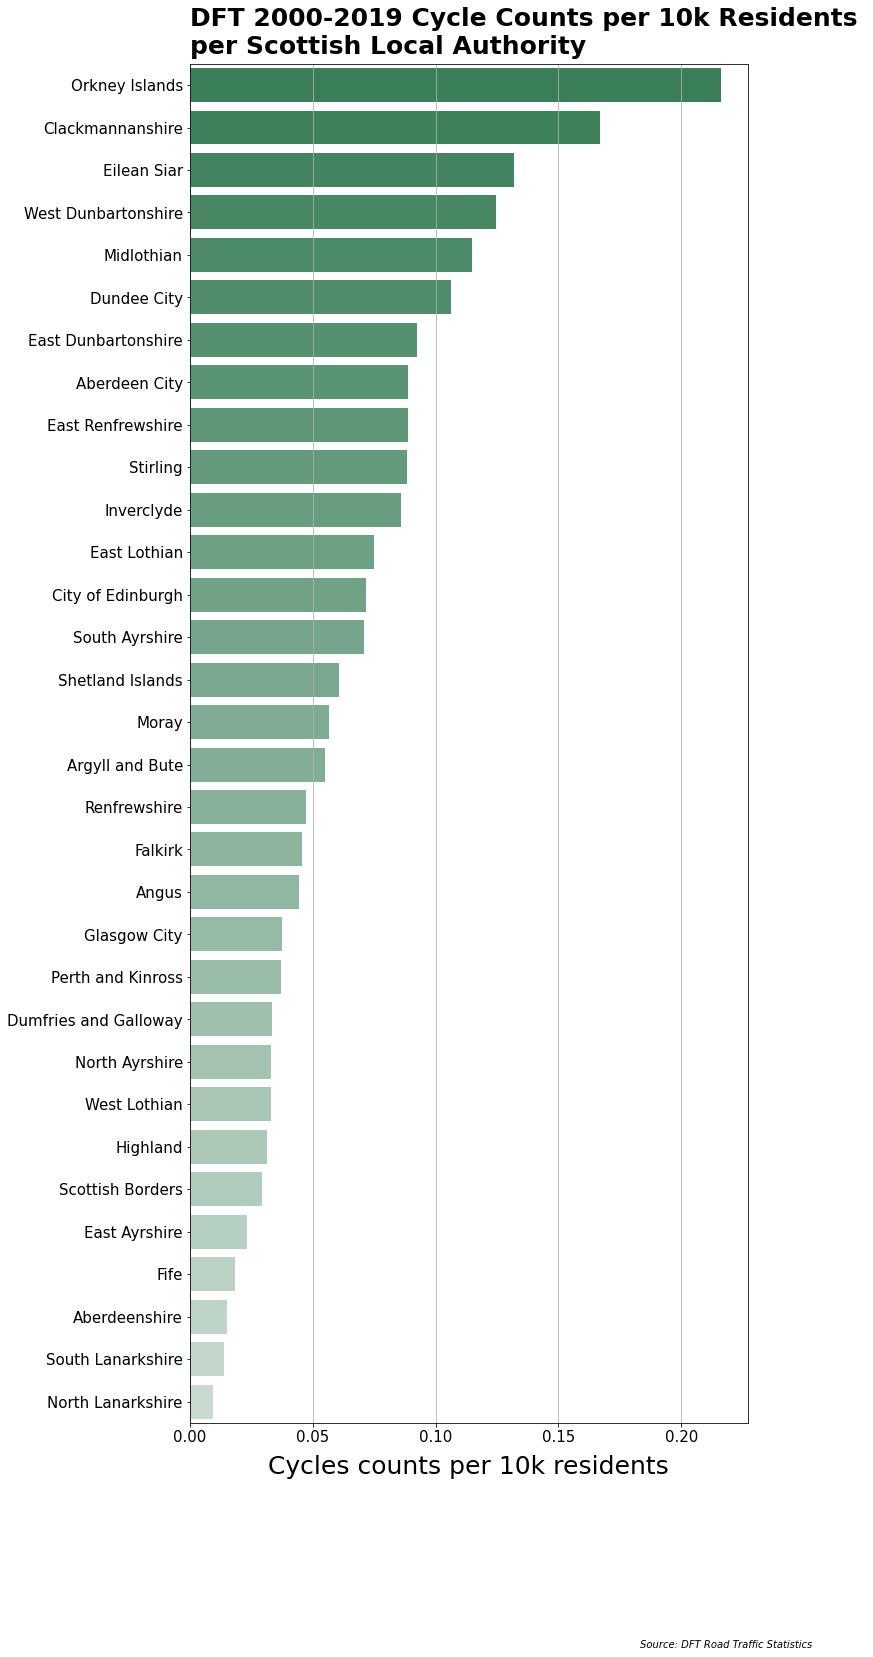

In [14]:
# Bar plot of bikes per 10k residents
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 25))
pal = sns.light_palette("seagreen", n_colors=40, reverse=True)
sns.barplot(x = bikes_per_10k_residents, y = bikes_per_10k_residents.index, palette=pal)
ax.set_title("DFT 2000-2019 Cycle Counts per 10k Residents \nper Scottish Local Authority",
            pad=10, loc = "left", fontdict={'weight':'heavy', 'color':'black'}, fontsize=25)
ax.set_ylabel("")
ax.set_xlabel("Cycles counts per 10k residents", fontsize=25, labelpad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figtext(x=.75, y=0, 
            s='Source: DFT Road Traffic Statistics', 
            fontdict={'style':'oblique', 'color':'black'})
plt.grid(which='major', axis='x')
plt.show()

# Q2: MapViz of Bikes

* Acquire topographical data (in TopoJSON format) that we converted into a map using GeoPandas - focus on authority borders
* Played around with the starting position when map is loaded due to the fact that Scotland has a few far-flung islands up North
* Choropleth map was coloured using population data with a single colour gradient - we thought this would look cleaner and less distracting compared to using multiple colours
* We wanted to display the bikes data points on each local authority and took two different approaches - one was to find the mean of lat/long in our data set, and one was to approximate central coordinates for each authority manually (with the Power of Google Maps) which gave us more control
 * Aside: we realised that as the coordinates in the data set are based on positions on roads, the mean coordinates are heavily biased towards road clusters
* We explored a number of different visual options for the choropleth map by changing 'tiles', highlighting, etc.
* An interesting exercise was parsing the TopoJSON data to pull out relevant authority names so we could use them as keys for our visualisation
* Finally, we ended up with circles located on the mean-central coordinates, with the radius controlled a scalar multiple of bike observations - scaling was of high magnitude for clearer visualisation

In [ ]:
# Selecting relevant columns for mapviz
map_cols = ['count_point_id', 'local_authority_name', 'count_date', 'road_name',
            'hour', 'direction_of_travel', 'latitude', 'longitude', 'population']
map_df = df_tidy[map_cols]

In [ ]:
# Manually finding central lat and long of 
# each local authority
auth_names = sorted(map_df.local_authority_name.unique())
lat_longs = [[57.148499575046166, -2.0994503154974553],[57.273760025881934, -2.5166643080179645],[56.72768401017168, -2.9246922126651884],[56.09740006583508, -5.505829190157146],[55.95233877595505, -3.188860106840768],[56.14959079238047, -3.7457616021792624],[55.085097679793755, -3.9648777663637222],[56.46547771536677, -2.9702673126999213],[55.465299446108205, -4.307460244966752],[55.950679905225755, -4.21793961543706],[55.943997191276125, -2.7324635644378654],[55.75505725179119, -4.362197202163319],[58.24343874214309, -6.382783267363518],[56.00349190992439, -3.7933138794341983], [56.246895135851844, -3.087199713717091],[55.85890878015006, -4.246879570599694],[57.47148264549703, -4.918077719700579],[55.910241417028985, -4.73843337649973],[55.8380756961132, -3.091164797971764],[57.507658214268204, -3.2238412189671544], [55.72279452380807, -4.743315946865488], [55.87990377885493, -3.943898088843739], [59.02526102084918, -3.006499055095088], [56.55895608244633, -3.8058868668882613], [55.84937262539755, -4.534918906544666], [55.580570268563, -2.726163579854028], [60.33439464263681, -1.2344978915362006], [55.29083618369606, -4.6958972343105625], [55.59988380366663, -3.7749667034686474], [56.22513721244209, -4.338586907406815], [55.982771806368184, -4.5149571176594625], [55.88803749019023, -3.570496063254735]]
coords_dict = dict(zip(auth_names, lat_longs)) 
coords_df = pd.DataFrame.from_dict(coords_dict, orient='index', columns=['cent_lat', 'cent_long'])
coords_df.reset_index(level=0, inplace=True)
coords_df.rename(columns={'index':'local_authority_name'}, inplace=True)

In [ ]:
# Finidng mean lat and long of each local authority
# and storing in new df
coords_df_tidy = df_tidy[['local_authority_name', 'latitude', 'longitude']]
coords_df_tidy = coords_df_tidy.groupby('local_authority_name')[['latitude', 'longitude']].mean()
coords_df_tidy.rename(columns={'latitude':'cent_lat', 'longitude':'cent_long'}, inplace=True) # Renaming columns
coords_df_tidy.reset_index(level = 0, inplace = True)

In [ ]:
# Full outer SQL join of map_df and coords_df_tidy
map_df = pd.merge(map_df, coords_df_tidy, on='local_authority_name', how='outer')

In [ ]:
# Matching dft authority names with external authority names
# JSON file is of local authority borders for choropleth map
auth_geo = os.path.join(os.getcwd(), 'data/local_auth.json')
with open(auth_geo) as f:
    scotland_topo = json.load(f)
topo_names = []
for i in range(32):
    topo_names.append(scotland_topo['objects']['lad']['geometries'][i]['properties']['LAD13NM'])

In [ ]:
# Reference: https://towardsdatascience.com/choropleth-maps-with-folium-1a5b8bcdd392
# Initialise map of Scotland
scotland_bright = folium.Map(location=[57.8906712, -4.2026458], zoom_start=6.25, tiles='cartodbpositron')

In [ ]:
# Create choloropleth of population data
choropleth = folium.Choropleth(geo_data = scotland_topo,              
    topojson = 'objects.lad',
    key_on ='feature.properties.LAD13NM',
    data = map_df,
    columns = ['local_authority_name', 'population'], 
    name ='choropleth',                                   
    fill_color = 'Blues', 
    fill_opacity = 1, # Prev 0.7
    line_opacity = 0.5, # Prev 0.2
    highlight = True,
    legend_name='Population',
    smooth_factor=0,
).add_to(scotland_bright) # Prev scotland

# Add labels indicating local authority name
style_function = "font-size: 12px"
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['LAD13NM'], style=style_function, labels=False))

# Add layer control
folium.LayerControl().add_to(scotland_bright)

In [ ]:
bikes_viz_df = bikes_per_10k_residents.to_frame()
bikes_viz_df.rename(columns={0:'bikes_10k'}, inplace=True)
bikes_viz_df.reset_index(level=0, inplace=True) # Resetting index
bikes_viz_df = pd.merge(bikes_viz_df, coords_df_tidy, on='local_authority_name', how='outer')

In [ ]:
# Add circles whose sizes represent bikes per 10k residents
normalizer = max(bikes_viz_df['bikes_10k'])
for auth_name in auth_names:
    folium.Circle(
        location = [bikes_viz_df.loc[bikes_viz_df['local_authority_name'] == auth_name]['cent_lat'].values[0], 
                bikes_viz_df.loc[bikes_viz_df['local_authority_name'] == auth_name]['cent_long'].values[0]],
        radius = float(bikes_viz_df.loc[bikes_viz_df['local_authority_name'] == auth_name]['bikes_10k'].values[0]*7e4),
        color = 'mediumseagreen',
        fill_color = 'mediumseagreen',
        popup = f"Bike density per 10k residents: {round(bikes_viz_df.loc[bikes_viz_df['local_authority_name'] == auth_name]['bikes_10k'].values[0], 3)}",
        tooltip=auth_name
    ).add_to(scotland_bright)

In [ ]:
scotland_bright

# Q3: roads + vehicles

* We had a series of visualisations of the entire range of vehicles
* In this one we wanted to see there was a difference in vehicle counts by month
* We noticed that the trend was typically in the following order: ...
* Across most months the trend in vehicle counts was consistent
* What was interesting was the nominal number of counts seemed to be quite low for specific months

* We hypothesised that DfT do not go out to look for specific vehicles (otherwise the trends would be quite different) but the reported counts are at least function of the different types of roads, given no other data
* So we created a similar visualisation but faceted it with the type of road and noticed:
 * For the months where fewer vehicles were observed, for certain types of roads, no counts were recorded at all, and for others, there was significant variance over the years
 * This leads us to hypothesise the reported counts are also a function of availability of DfT staff - for example, July and August are typically school holidays so most working parents (and non-parents) are on vacation, and November is the lead up to Christmas (also it's cold!)
* Note:
 * 278 A roads
 * 206 B roads
 * 9   M roads
 * Undefined C/U roads

In [ ]:
extract_road_letters = np.vectorize(lambda string: string[0])

for road_counts in zip(*np.unique(extract_road_letters(df_tidy.road_name.unique()), return_counts = True)):
    if road_counts[1] > 1:
        print(f"There are {road_counts[1]} {road_counts[0]} roads.")

In [ ]:
# Defining months for ordering purposes
months = ["March", "April", "May", "June", "July", "August",
          "September", "October", "November"]

# Extract relevant columns for observing variation of counts
# over the different months for different vehicles
vehicle_cols = ['count_date', 'bikes', 'motorcycles', 'cars', 'buses', 'lgvs', 'hgvs']
vehicle_df = df_tidy.copy()
vehicle_df = vehicle_df[vehicle_cols]
# Create new column for month name
vehicle_df.loc[:,'month'] = vehicle_df['count_date'].dt.month_name()
# Ordering month_df chronologically
vehicle_df.loc[:,'month'] = pd.Categorical(vehicle_df['month'], categories=months, ordered=True)
vehicle_df.sort_values(by='month', inplace=True)

In [ ]:
sns.set_theme(style='whitegrid', font_scale=1.5)

# Create the PairGrid
vg = sns.PairGrid(vehicle_df.sort_values('cars', ascending=False),
                 x_vars=vehicle_df.columns[1:-1], y_vars=['month'],
                 height=10, aspect=.25)
plt.subplots_adjust(top=.875)
vg.fig.suptitle("DFT Distribution of Vehicles Counts by Month 2000-2019",  
                fontdict={'weight':'bold', 'color':'black'},
                fontsize=30)

# Draw a scatter plot using stripplot function
vg.map(sns.stripplot, size=7.5, orient='h', marker='o',
       palette='flare_r', linewidth=1, edgecolor='none',  alpha=.5)

# Use semantically meaningful titles for the columns
titles = ["Bikes", "Motorcycles", "Cars", "Buses",
          "LGVS", "HGVS"]

for ax, title in zip(vg.axes.flat, titles):
    # Set a different title for each axes
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(True)
    ax.yaxis.grid(False)

sns.despine(left=True, bottom=True)

In [ ]:
# Extract relevant columns for observing variation of counts
# over the different months for different road_types
roads_cols = ['count_date', 'road_type']
roads_df = df_tidy[roads_cols]

In [ ]:
# Pivoting data wider so M, A, B, C, U become columns
roads_df = roads_df.pivot_table(index=['count_date'], columns=['road_type'], aggfunc=len, fill_value=0)

In [ ]:
roads_df.reset_index(level=0, inplace=True)

In [ ]:
# Making type_df chronologically ordered
roads_df['month'] = roads_df['count_date'].dt.month_name()
roads_df['month'] = pd.Categorical(roads_df['month'], categories=months, ordered=True)
roads_df.sort_values(by='month', inplace=True)

In [ ]:
# Reordering type_df columns
roads_cols = ['count_date', 'month', 'M', 'A', 'B', 'C', 'U']
roads_df = roads_df.reindex(columns=roads_cols)

In [ ]:
sns.set_theme(style='whitegrid', font_scale=1.5)
# Create the PairGrid
roads_g = sns.PairGrid(roads_df.sort_values('A', ascending=False),
                 x_vars=roads_df.columns[2:], y_vars=['month'],
                 height=10, aspect=.25)
plt.subplots_adjust(top=.835)
roads_g.fig.suptitle("DFT Distribution of Road Type Counts \nby Month 2000-2019",  
                fontdict={'weight':'bold', 'color':'black'},
                fontsize=30)


# Draw a scatter plot using stripplot function
roads_g.map(sns.barplot, palette="flare_r")

# Use semantically meaningful titles for the columns
titles = ["M", "A", "B", "C", "U"]

for ax, title in zip(roads_g.axes.flat, titles):
    # Set a different title for each axes
    ax.set_title(title, fontsize=20)
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.set_ylabel("")
    ax.set_xlabel("")
    
sns.despine(left=True, bottom=True)

# ~Q1: Bar chart of [X] longest roads showing start and end locations~

### Method
* Filter by distinguishing road name 
* Ignore U and C roads 
* We have start and end junctions (general locations)
* How do we calculate distance?
    1. Add up link lengths
    2. Verify with Google Maps



# ~Q2: Local authorities managing number of roads - mapviz - fixed point in time~

### Outcome
* 2019 map of roads managed
* Static map of Scotland with gradient colour scheme

### Method
* Group by `local_authority_name`, `count_id`
* Break down total number of roads per authority into `road_names`
* Possible weight matrix to give larger, busier roads a larger influence in the map - don't want to give U and C thes same weighting as M and A roads
* In `road_name` variable, cut string such that it's only a single character

### Stretch and Challenge
* Maintenance data to observe which authority spends the most on maintainance

### Extra Packages:
* folium
* geopandas


# Q3: Interactive visualization of the usage of Cycles on motorways in Scotland ~distribution of vehicles over each type of road over the past [X] years~ from 2000 to 2019

### Outcome
* x-axis: discrete vehicle type data e.g.  cars, bikes, buses, hgvs, lgvs etc
* y-axis: type of road e.g. M, A, B, C, U
* Scatter point for each category where size indicates prevalence of that type of vehicle on that type of road
* Slider which shows variation of data over [X] years


### Method
* Group C and U roads
* Normalize scatter points by \pi*R^2


### Stretch and Challenge
* We have dotted line outline of average of previous 5 years giving the reader some indication of growth/reduction
* x-axis: as emojis


### Extra packages
* plotly - used to vary the datapoints



* Out of curiosity we wanted to see the usage of HGVs on different types of roads (we hypothesised that it would be unlikely to see them on U/C roads - or at least very few of them)
* To do this we tried a different map set - a shape file of the road network in Scotland
* We filtered the data based on HGVs, and only retained rows where at least one HGV was observed
* We had to use the `Shapely` library to convert the coordinates into a tuple-esque coordinate object, and then  plotted the points using `GeoPandas` 
* The resulting visualisation wasn't as scandalous as we would have liked so we thought out a different case: would you ever expect to see cycles on Motorways (which is illegal)?
* It turned out that a particular stretch of some motorways saw a particularly large number of cycles observed (for a motorway and given the illegality, anything more than 0 counts as large!):
 * M8 on 11/06/00
 * M90 on 11/04/00 and 23/06/00
* Desite our best efforts, we could not find any news or events to corroborate this (this was one article regarding roadworks for M80 where the speed limit was dropped to 40mph) so it either remains a mystery or a massive error (which is very unlikely)

In [ ]:
# Unique roads, because we can
unique_motorways = df_tidy.loc[df_tidy.road_type == 'M'].road_name.unique()

In [ ]:
# Extracting HGV-only data
bikem_cols = ['count_date', 'hour', 'road_name', 'road_type', 'latitude', 'longitude', 'bikes']
bikem_df = df_tidy[bikem_cols]
bikem_df = bikem_df.loc[bikem_df['bikes'] > 0]

In [ ]:
bikem_df.loc[(bikem_df['road_type']=='M')]

In [ ]:
# Creating Point objects for plotting HGV counts and their locations
# on gpd map
geometry = [Point(xy) for xy in zip(bikem_df['longitude'], bikem_df['latitude'])]
# Specifying coordinate reference system
crs = {'init': 'EPSG:4326'}
bikem_df.drop(['latitude', 'longitude'], inplace=True, axis = 1) # drop unnessecary cols

In [ ]:
geo_df = gpd.GeoDataFrame(bikem_df, crs = crs, geometry = geometry) # Create geodf

In [ ]:
# Read in external shape file of Scottish roads
scotland_roads = gpd.read_file('data/roads.shp')

In [ ]:
#scotland_auth_shape = gpd.read_file('pub_las.shp')

In [ ]:
fig, axis = plt.subplots(figsize = (12, 20))
scotland_roads.plot(ax = axis, color = 'gray', alpha = 0.2)
#scotland_auth_shape.plot(ax = axis, color = 'white', edgecolor = 'black')
#geo_df[geo_df['road_type'] == 'U'].plot(ax = axis, markersize = 15, color = 'red', marker = 'o', label = 'U')
#geo_df[geo_df['road_type'] == 'C'].plot(ax = axis, markersize = 15, color = 'green', marker = 'o', label = 'C')
geo_df[geo_df['road_type'] == 'M'].plot(ax = axis, markersize = 200, color = 'firebrick', marker = 'x', label = 'M')
plt.legend(prop = {'size': 15})
plt.show()

# Q4: Time of day viz?

### Outcome
* x-axis: Hours of the day (07:00 - 18:00)
* y-axis-1: `all_vehicles`
* y-axis-2: types of vehicle (faceted plot)
* Light alpha filled densities

### Method
* Get hours day
* Group vehicle count by hour type
* Further subset those counts by vehicle

* Answering one of the provided questions, we wanted a nice-looking distribution plot of vehicle counts per hour of day
* We decided to use the scheme and some formatting from the `FiveThirtyEight` theme
* As this is a graph we expect many people to provide, we wanted to make it look a little snazzier by directly annotating the vehicle type on the graph itself in a visually engaging way
* Observations:
 * Follows an expected trend with peaks in the morning (commuter traffic) and evening
 * Typically more observations at the end of day suggesting it is a mix of commuter and leisure traffic (going out for the evening after work)
 * HGVs bucked this trend which we surmise because their work involves driving them to and from depots and distribution centres during working hours

In [ ]:
tod_df = df_tidy[['hour'] + new_names] # Extracting relevant variables
tod_df = tod_df.groupby('hour').sum()  # Find total counts of each vehicle at every hour
tod_df.reset_index(level=0, inplace=True) # Index with numbers not names
tod_df = tod_df.melt(id_vars='hour', var_name='vehicle_type') # Pivot longer
tod_df.vehicle_type = tod_df.vehicle_type.astype('category')  # Converting datatype to categorical

In [ ]:
# Define relevant data to plot
x = tod_df.hour.unique()
y1 = tod_df.loc[tod_df.vehicle_type=='cars']['value']
y2 = tod_df.loc[tod_df.vehicle_type=='lgvs']['value']
y3 = tod_df.loc[tod_df.vehicle_type=='hgvs']['value']
y4 = tod_df.loc[tod_df.vehicle_type=='buses']['value']
y5 = tod_df.loc[tod_df.vehicle_type=='motorcycles']['value']
y6 = tod_df.loc[tod_df.vehicle_type=='bikes']['value']
y = [y1, y2, y3, y4, y5, y6] # Amalgamate into single list

In [ ]:
labels = ["CARS", "LGVS", "HGVS", "BUSES", "MOTORBIKES", "BIKES"]
xticks_ = np.arange(7, 19)

In [ ]:
plt.style.use('fivethirtyeight')
# Plotting facetgrid manually
fig, axes = plt.subplots(6, 1, sharex=False, sharey=False, figsize=(16, 32), facecolor='white')
plt.subplots_adjust(top=.94)

fig.suptitle("DFT Distribution of Vehicles Counts \nby Hour 2000-2019",  
                fontdict={'weight':'bold', 'color':'black'},
                fontsize=40)
hues = ['#e5ae38', '#8b8b8b', '#6d904f', '#fc4f30', '#810f7c', '#008fd5']
for i, ax in enumerate(axes):
    sns.lineplot(data=tod_df, x='hour', y=y[i], ax=ax, hue='vehicle_type')
    ax.fill_between(x, y[i], color=hues[i], alpha=0.35)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticks(xticks_),
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f')),
    ax.get_legend().remove()
    t = ax.annotate(f"{labels[i]}", 
                xy=(10,10), 
                xycoords='data', 
                textcoords='axes fraction', 
                xytext=(.94,.075),
                ha='right',
                fontsize=60,
                fontweight='bold',
                color='white')
    t.set_path_effects([path_effects.Stroke(linewidth=5, foreground=hues[i]),
                       path_effects.Normal()])
    ax.set_facecolor("white")
    ax.xaxis.grid(True)
    ax.yaxis.grid(False)
    sns.despine(left=True, bottom=True)

### TODOs for Q4:

* Add all hours to x-axis
* Format y-axis, and change labels
* Add hover on hour points to read values
* Display legend of colour <--> vehicle_type

# Q5: Bikes observed per 10k residents / capita per local authority 

### Caveats
1. Count data of bikes is assumed to be representative of the prevalence of bikes in the authority
2. A bike count within a local authority maps to that bike actually belonging to that authority
3. Double counting effects are ignored

This is because bikes are not registered vehicles and hence this assumption has to be made. We think this is a reasonable assumption since bikes are used for micro-mobility in the majority of cases.

### Outcome
* Horizontal bar chart ordered in descending order

### Method
* Get population data and store in tidy dataframe
* Plot the data

## Additional
* Encode or visualise population data
* Bikes per 10,000 residents - same as log